In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from nltk.stem.porter import PorterStemmer

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
import pickle
import os

In [2]:
#creating dataframe from sql file

con=sqlite3.connect('database.sqlite')
df=pd.read_sql_query("""select * from Reviews where Score!=3 """,con)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#function for mapping positive and negative reviews

def partition(x):
    if x<3:
        return 0
    if x>3:
        return 1
    
df['Score']=df['Score'].map(partition)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
type(df['Score'])

pandas.core.series.Series

In [6]:
#finding duplicacy 
d=pd.read_sql_query("""select * from Reviews where Score!=3 AND UserId='AR5J8UI46CURR' """,con)
d

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
#sorting dataframe
sorted_data=df.sort_values('ProductId',ascending=True,axis=0,inplace=False,kind='quicksort',na_position='last')

In [10]:
#deleting duplicate rows
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Text','Time'},keep='first',inplace=False)
final.shape

(364173, 10)

In [11]:
#checking what percentage of duplicacy has been removed
(final['Score'].size*1.0)/(df['Score'].size*1.0)*100

69.25890143662969

In [13]:
#finding html tags
i=0
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break
    i+=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [15]:
#setting stopwords
stop=set(stopwords.words('english'))

#initilizing Snowball Stemming

sno=nltk.stem.SnowballStemmer('english')

#function for cleaning html tags
def cleanhtml(sent):
    cleaner=re.compile('<.*?>')
    cleaned=re.sub(cleaner,' ',sent)
    return cleaned

#function for cleaning punctuation
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

print(stop)
print("##########################################################")
print(sno.stem('tasty'))

{'from', 'himself', 'i', 'weren', 'ain', 'when', 'most', "hadn't", 're', 'shan', "should've", 'doesn', "you're", "aren't", 'hasn', 'can', "won't", 'the', 'its', 'have', 'he', 'him', 'being', 'as', 'your', 'who', 'up', "you'd", 'how', 'having', 'aren', 'only', "don't", 'doing', 'they', 'be', 'll', "she's", 's', 'any', "didn't", 'this', 'do', 'don', 't', "you'll", 'were', 'in', 'didn', 'had', 'did', 'after', 'd', 'is', "that'll", 'during', 'out', 'there', 'before', 'below', 'all', 'off', "doesn't", 'further', 'on', "shan't", 'other', 'her', 'but', 'which', 'myself', 'won', 'haven', 'yourselves', 'are', "shouldn't", 'just', 'that', "mustn't", 'here', 've', 'an', 'again', 'own', 'our', 'hadn', 'been', 'down', 'against', 'ours', 'once', 'hers', 'at', 'where', 'what', 'until', 'these', 'itself', 'of', "couldn't", 'their', 'if', 'isn', 'those', 'such', 'shouldn', "wasn't", 'under', 'yours', 'and', 'm', 'then', "haven't", 'by', 'or', 'no', 'mustn', 'very', 'both', 'my', 'same', 'above', 'a', '

In [17]:
#code for implimenting step by step the check of Preprocessing

if not os.path.isfile('final.csv'):
    i=0
    str1=''
    final_string=[]
    all_pos_words=[]
    all_neg_words=[]
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sent=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha())& (len(cleaned_words)>2)):
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sent.append(s)
                        
                        if(final['Score'].values[i]==1):
                            all_pos_words.append(s)
                        if(final['Score'].values[i]==0):
                            all_neg_words.append(s)
                        
                    else:
                        continue
                else:
                    continue
        str1=b" ".join(filtered_sent)
        final_string.append(str1)
        i+=1
        

100%|██████████| 364173/364173 [06:20<00:00, 956.35it/s] 


In [19]:
#adding a new column
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode('utf-8')
final['CleanedText'].head()

138706    witti littl book make son laugh loud recit car...
138688    grew read sendak book watch realli rosi movi i...
138689    fun way children learn month year learn poem t...
138690    great littl book read nice rhythm well good re...
138691    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [20]:
#saving the dataframe into a new csv file
final.to_csv('final.csv')

In [21]:
final=pd.read_csv('final.csv')
final.shape

(364173, 12)

In [22]:
#taking top 5k points
d_pos=final[final['Score']==1].sample(2500)
d_neg=final[final['Score']==0].sample(2500)
final_5k=pd.concat([d_pos,d_neg])
score_5k=final_5k['Score']
final_5k.shape

(5000, 12)

In [23]:
#bag of words
count_vect=CountVectorizer()
final_counts=count_vect.fit_transform(final_5k['CleanedText'])
final_counts.shape

(5000, 9900)

In [26]:
#standardizing
from sklearn.preprocessing import StandardScaler
std_data=StandardScaler(with_mean=False).fit_transform(final_counts)
print(type(std_data))
std_data=std_data.todense()
print(type(std_data))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


In [29]:
#TSNE
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
tsne_data=model.fit_transform(std_data)

In [30]:
#adding score 
tsne_data=np.vstack((tsne_data.T,score_5k)).T

#creating dataframe
tsne_df=pd.DataFrame(tsne_data,columns=('d1','d2','Score'))
tsne_df.head()

,d1,d2,Score
0,-10.770895,-4.924822,1.0
1,21.695810,-19.996290,1.0
2,-2.269511,24.110182,1.0
3,18.757193,-7.453103,1.0
4,38.351360,15.857020,1.0


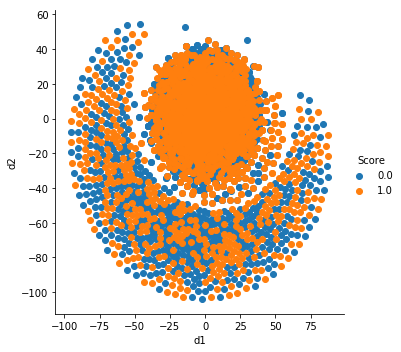

In [32]:
#plotting with seaborn
sns.FacetGrid(tsne_df,hue='Score',size=5)\
   .map(plt.scatter,'d1','d2')\
   .add_legend()

In [33]:
#tfidVectorizer

tfidf_vect=TfidfVectorizer()
final_tfidf=tfidf_vect.fit_transform(final_5k['CleanedText'])
final_tfidf.shape

(5000, 9900)

In [35]:
#standardizing
std_data=StandardScaler(with_mean=False).fit_transform(final_tfidf)
print(type(std_data))
std_data=std_data.todense()
print(type(std_data))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


In [36]:
#tsne
model=TSNE(n_components=2,random_state=0)
tsne_data=model.fit_transform(std_data)

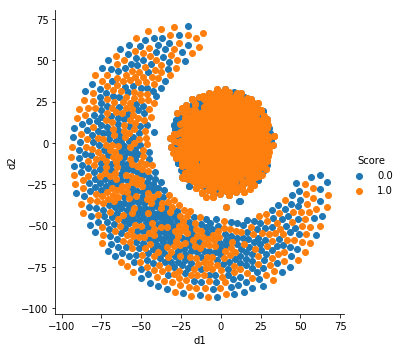

In [38]:
#adding Score
tsne_data=np.vstack((tsne_data.T,score_5k)).T

#creating DatFrame
tsne_df=pd.DataFrame(tsne_data,columns=('d1','d2','Score'))

#plotting with seaborn

sns.FacetGrid(tsne_df,hue='Score',size=5)\
   .map(plt.scatter,'d1','d2')\
   .add_legend()

In [40]:
#training own word2Vec model
i=0
list_of_sent=[]
for sent in final_5k['CleanedText'].values:
    list_of_sent.append(sent.split())

In [45]:
print(final['CleanedText'].values[0])
print('**************************************')
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
**************************************
['everyth', 'came', 'perfect', 'condit', 'excel', 'slip', 'paper', 'detail', 'pretti', 'much', 'everyth', 'need', 'know', 'product', 'plant', 'look', 'healthi', 'good', 'condit', 'moss', 'perfect', 'fine', 'look', 'forward', 'plant', 'tomorrow']


In [46]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [47]:
w2v_words=list(w2v_model.wv.vocab)


In [49]:
w2v_model.wv.most_similar('like')

[('tast', 0.9855250120162964),
 ('sweet', 0.9844808578491211),
 ('flavor', 0.9829907417297363),
 ('chocol', 0.9735168218612671),
 ('hot', 0.9685711860656738),
 ('realli', 0.9663610458374023),
 ('drink', 0.9623351693153381),
 ('strong', 0.9560649991035461),
 ('milk', 0.9537758827209473),
 ('add', 0.9511140584945679)]

In [50]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:05<00:00, 876.91it/s]

5000
50
